### Scatter plot comparisons

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import pandas as pd
import pickle
import seaborn as sns
import xarray as xr
import cmocean
import geo_tools
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

##### Parameters

Tuning sets:
- ref_2015:   sediment in ice = 0.00, resuspension_constant = 1.0, gamma = 0.04
- oldice:     sediment in ice = 0.05, resuspension_constant = 1.0, gamma = 0.04 (up to spinup2)
- gamma006:   sediment in ice = 0.00, resuspension_constant = 1.0, gamma = 0.06 (up to spinup2)
- upconstant: sediment in ice = 0.00, resuspension_constant = 3.0, gamma = 0.04 (up to spinup0)

In [6]:
# domain dimensions:
imin, imax = 1480, 2180
jmin, jmax = 160, 800

month   = 8

# results to load:
oldref_2015        = '/data/brogalla/run_storage/Mn-set4-202004/ref-2015/ANHA12_EXH006_2015_monthly.nc'
ref_2015           = '/data/brogalla/run_storage/Mn-reference-202102/ref-2015-202102/ANHA12_EXH006_2015_monthly.nc'
spinup0_2015       = '/data/brogalla/run_storage/Mn-reference-202102/spin-up0-202102/ANHA12_EXH006_2002_monthly.nc'
spinup2_2015       = '/data/brogalla/run_storage/Mn-reference-202102/spin-up2-202102/ANHA12_EXH006_2002_monthly.nc'
oldice_spinup2     = '/data/brogalla/run_storage/Mn-tuning-202103/spin-up2-oldice/ANHA12_EXH006_2002_monthly.nc'
# gamma006_spinup2   = '/data/brogalla/run_storage/Mn-tuning-202103/spin-up2-erosion006/ANHA12_EXH006_2002_monthly.nc'
gamma006_spinup2   = '/data/brogalla/run_storage/spin-up2-202103/ANHA12_EXH006_2002_monthly.nc'
upconstant_spinup0 = '/data/brogalla/run_storage/Mn-tuning-202103/spin-up0-upconstant/ANHA12_EXH006_2002_monthly.nc'

# colours:
c_continent    = '#ce9169'
c_glacier      = '#36ab92'
c_other        = '#a6a6a6'
land_color     = "#8b7765"

In [7]:
file_list = [oldref_2015, ref_2015, spinup0_2015, spinup2_2015, oldice_spinup2, gamma006_spinup2, upconstant_spinup0]

##### Load files

In [8]:
Mn_model     = nc.Dataset(oldref_2015)
lon_model    = np.array(Mn_model.variables['nav_lon'])
lat_model    = np.array(Mn_model.variables['nav_lat'])
depths_model = np.array(Mn_model.variables['deptht'])

In [9]:
mesh       = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh1.nc')
mesh_lon   = np.array(mesh.variables['nav_lon'])
mesh_lat   = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'][0])

In [10]:
mask     = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh_zgr10.nc')
tmask    = mask.variables['tmask']
tmask    = np.array(tmask[0,:,:,:])
mlons    = np.array(mask.variables['nav_lon'])
mlats    = np.array(mask.variables['nav_lat'])
Z_masked = np.ma.masked_where((tmask > 0.1), tmask)

Observations

In [11]:
station_names = ['CAA1', 'CAA2', 'CAA3', 'CAA4', 'CAA5', 'CAA6', 'CAA7', 'CAA8', 'CAA9', \
                'CB1', 'CB2', 'CB3', 'CB4']
station_stdev = ['Unnamed: 17', 'Unnamed: 20','Unnamed: 26', 'Unnamed: 29', 'Unnamed: 32', 'Unnamed: 35', \
                 'Unnamed: 38', 'Unnamed: 41','Unnamed: 44', 'Unnamed: 47', 'Unnamed: 50', 'Unnamed: 53']
station_depth = ['Depth.5','Depth.6','Depth.7','Depth.8','Depth.9','Depth.10','Depth.11','Depth.12','Depth.13', \
                'Depth.14','Depth.15','Depth.16','Depth.17']

In [12]:
observations = {'dissolmn': np.zeros((13,25)), 
                'stdev':np.zeros((13,25)), 
                'depth':np.zeros((13,25))} # dimensions: stations, depths
Mn_data      = pd.read_csv('/data/brogalla/Mn_Integrated_Data_UBC-UVic_4-17-19.csv')

for it, stn in enumerate(station_names):
    length = len(Mn_data[stn].dropna()[1:].astype('float'))
    observations['dissolmn'][it][0:length] = Mn_data[stn].dropna()[1:].astype('float')
        
for it, stn in enumerate(station_stdev):
    if stn=='Unnamed: 44':
        length = 11
        observations['stdev'][it][0:length] = Mn_data[stn][1:].astype('float').fillna(0)[0:11]
    elif stn=='Unnamed: 50':
        length = 22
        observations['stdev'][it][0:length] = Mn_data[stn][1:].astype('float').fillna(0)[0:22];
    else:
        length = len(Mn_data[stn].dropna()[1:].astype('float'))
        observations['stdev'][it][0:length] = Mn_data[stn].dropna()[1:].astype('float')
        
for it, stn in enumerate(station_depth):
    length = len(Mn_data[stn].dropna())
    observations['depth'][it][0:length]    = Mn_data[stn].dropna()

In [13]:
observations['dissolmn'][observations['dissolmn'] == 0] = np.nan

Mask bottom values of CAA2 and CAA7 (extreme spikes)

In [14]:
#CAA2:
observations['dissolmn'][1,11] = np.nan
#CAA7:
# observations['dissolmn'][6,6]  = np.nan
observations['dissolmn'][6,7]  = np.nan

In [15]:
Pb_data   = pd.read_csv('/data/brogalla/Pb-paper-data.csv')
stn_names = Pb_data['Station names'][5:].dropna().astype('str')
lons      = Pb_data['station lon'][5:].astype('float').dropna().values
lats      = Pb_data['Station lat'][5:].astype('float').dropna().values

Get indices

In [16]:
stationi = np.empty((len(lons)))
stationj = np.empty((len(lons)))
for it, (lon, lat) in enumerate(zip(lons, lats)):
    i, j = geo_tools.find_closest_model_point(lon, lat, mesh_lon, mesh_lat, tols={
        'NEMO': {'tol_lon': 0.08, 'tol_lat': 0.015},
        })
    stationi[it] = i
    stationj[it] = j

In [17]:
stationi[2] = stationi[2]+1 # otherwise I think it's on land

In [18]:
# Match the depths of the observations with the model depths:
stationk = np.empty((13,25))
for stn in range(0,len(lons)):
    depths_obs = observations['depth'][stn,:]
    depths_obs[depths_obs==0] = np.nan
    for ind, depth in enumerate(depths_obs):
        k = np.argmin(np.abs(depths_model-depth))
        stationk[stn, ind] = k
        
stationk[stationk==0] = np.nan

Load model data

In [19]:
tuning_series = {'dissolmn': np.zeros((len(file_list),13,25))} # dimensions: tuning run, depth, stations
for it, filename in enumerate(file_list):
        data = xr.open_dataset(filename)
        for n, (i, j) in enumerate(zip(stationi, stationj)):
            for ind, k in enumerate(stationk[n,:]):
                try:
                    tuning_series['dissolmn'][it,n,ind] = data['dissolmn'][month,0,int(k),int(i-imin),int(j-jmin)]
                except:
                    tuning_series['dissolmn'][it,n,ind] = np.nan
        data.close()

In [20]:
tuning_series['dissolmn'][tuning_series['dissolmn'] == 0] = np.nan

### different parameter sets

Tuning sets:
- ref_2015:   sediment in ice = 0.00, resuspension_constant = 1.0, gamma = 0.04
- oldice:     sediment in ice = 0.05, resuspension_constant = 1.0, gamma = 0.04 (up to spinup2)
- gamma006:   sediment in ice = 0.00, resuspension_constant = 1.0, gamma = 0.06 (up to spinup2)
- upconstant: sediment in ice = 0.00, resuspension_constant = 3.0, gamma = 0.04 (up to spinup0)

Order of data: file_list = [oldref_2015, ref_2015, spinup0_2015, spinup2_2015, oldice_spinup2, gamma006_spinup2, upconstant_spinup0]

In [21]:
c_tuning1 = '#ffe040'
c_tuning2 = '#7fa5f2'
c_tuning3 = '#9370db'
c_tuning4 = '#80d6ab'
c_tuning5 = '#9a004d'

In [23]:
# x-axis: year of spin-up
# y-axis: mean deviation from observations
# each runset has 1 color
resus_constant = (tuning_series['dissolmn'][6]-tuning_series['dissolmn'][2])/(3.0-1.0) # at spin-up0
sedice_content = (tuning_series['dissolmn'][4]-tuning_series['dissolmn'][3])/(0.05-0.00) # at spin-up2
# gamma_value    = (tuning_series['dissolmn'][5]-tuning_series['dissolmn'][3])/(0.06-0.04) # at spin-up2
gamma_value    = (tuning_series['dissolmn'][5]-tuning_series['dissolmn'][3])/(0.075-0.04) # at spin-up2

In [24]:
# OR use 2015 tuning5 estimate to alter the other points

resus_rate = np.linspace(0,24,100) # sediment resuspension rate constant
sed_ice    = np.linspace(0,0.15,100) # background sea ice sediment content
gamma      = np.linspace(0,0.5,80) # gamma
parameter_sets = {'resus_rate': np.zeros((100,100,80)), 'sed_ice':np.zeros((100,100,80)), 'gamma': np.zeros((100,100,80)), \
                  'model_diff':np.zeros((100,100,80))}

mean_obs = np.nanmean(observations['dissolmn'].flatten())

for gt, g_param in enumerate(gamma):
    for it, r_param in enumerate(resus_rate):
        for jt, si_param in enumerate(sed_ice):
            parameter_sets['resus_rate'][it,jt,gt] = r_param
            parameter_sets['sed_ice'][it,jt,gt]    = si_param 
            parameter_sets['gamma'][it,jt,gt]      = g_param 

            mod      = tuning_series['dissolmn'][3] - (0.0*sedice_content + 1.0*resus_constant + 0.04*gamma_value) \
                                + (resus_constant*r_param + sedice_content*si_param + gamma_value*g_param)
            mean_mod = np.nanmean(mod.flatten()*10**9)

            parameter_sets['model_diff'][it,jt,gt] = mean_mod - mean_obs

In [25]:
max_depth = np.nanmax(observations['depth'],axis=1)
depth_bdy = max_depth - 100 # for looking at the bottom, calculate the bottom depth

In [26]:
# OR use 2015 tuning5 estimate to alter the other points

resus_rate = np.linspace(0,24,100) # sediment resuspension rate constant
sed_ice    = np.linspace(0,0.15,100) # background sea ice sediment content
gamma      = np.linspace(0,0.5,80) # gamma
bottom_parameter_sets = {'resus_rate': np.zeros((100,100,80)), 'sed_ice':np.zeros((100,100,80)), 'gamma': np.zeros((100,100,80)), \
                          'model_diff':np.zeros((100,100,80))}

for gt, g_param in enumerate(gamma):
    for it, r_param in enumerate(resus_rate):
        for jt, si_param in enumerate(sed_ice):
            bottom_parameter_sets['resus_rate'][it,jt,gt] = r_param
            bottom_parameter_sets['sed_ice'][it,jt,gt]    = si_param 
            bottom_parameter_sets['gamma'][it,jt,gt]      = g_param 

            bottom_obs = np.zeros(13)
            bottom_mod = np.zeros(13)
            for stn, depth_lim in enumerate(depth_bdy):     
                mod = tuning_series['dissolmn'][3,stn,:][observations['depth'][stn,:] > depth_lim] - \
                            (0.0*sedice_content[stn,:][observations['depth'][stn,:] > depth_lim] + \
                             1.0*resus_constant[stn,:][observations['depth'][stn,:] > depth_lim] + \
                             0.04*gamma_value[stn,:][observations['depth'][stn,:] > depth_lim]) \
                            + resus_constant[stn,:][observations['depth'][stn,:] > depth_lim]*r_param + \
                            sedice_content[stn,:][observations['depth'][stn,:] > depth_lim]*si_param + \
                            gamma_value[stn,:][observations['depth'][stn,:] > depth_lim]*g_param
                bottom_obs[stn] = np.nanmean(observations['dissolmn'][stn,:][observations['depth'][stn,:] > depth_lim])
                bottom_mod[stn] = np.nanmean(mod.flatten()*10**9)

            bottom_parameter_sets['model_diff'][it,jt,gt] = np.nanmean(bottom_mod) - np.nanmean(bottom_obs)

In [27]:
# OR use 2015 tuning5 estimate to alter the other points

resus_rate = np.linspace(0,24,100) # sediment resuspension rate constant
sed_ice    = np.linspace(0,0.15,100) # background sea ice sediment content
gamma      = np.linspace(0,0.5,80) # gamma
upper_parameter_sets = {'resus_rate': np.zeros((100,100,80)), 'sed_ice':np.zeros((100,100,80)), 'gamma': np.zeros((100,100,80)), \
                      'model_diff':np.zeros((100,100,80))}

upper_obs = np.nanmean(observations['dissolmn'][observations['depth'] < 100])

for gt, g_param in enumerate(gamma):
    for it, r_param in enumerate(resus_rate):
        for jt, si_param in enumerate(sed_ice):
            upper_parameter_sets['resus_rate'][it,jt,gt] = r_param
            upper_parameter_sets['sed_ice'][it,jt,gt]    = si_param 
            upper_parameter_sets['gamma'][it,jt,gt]    = g_param 

            upper_mod = tuning_series['dissolmn'][3][observations['depth'] < 100] - \
                        (0.0*sedice_content[observations['depth'] < 100] + 1.0*resus_constant[observations['depth'] < 100] + \
                        0.04*gamma_value[observations['depth'] < 100]) \
                        + resus_constant[observations['depth'] < 100]*r_param + sedice_content[observations['depth'] < 100]*si_param + \
                        gamma_value[observations['depth'] < 100]*g_param
            upper_mod = np.nanmean(upper_mod.flatten()*10**9)

            upper_parameter_sets['model_diff'][it,jt,gt] = upper_mod - upper_obs

In [29]:
# Bring spinup experiment --> future

# oldice:     sediment in ice = 0.05, resuspension_constant = 1.0, gamma = 0.04 (up to spinup2)
oldice_2015     = tuning_series['dissolmn'][4]+(tuning_series['dissolmn'][1] - tuning_series['dissolmn'][3])
# gamma006:   sediment in ice = 0.00, resuspension_constant = 1.0, gamma = 0.06 (up to spinup2)
gamma006_2015   = tuning_series['dissolmn'][5]+(tuning_series['dissolmn'][1] - tuning_series['dissolmn'][3])
# upconstant: sediment in ice = 0.00, resuspension_constant = 3.0, gamma = 0.04 (up to spinup0)
upconstant_2015 = tuning_series['dissolmn'][6]+(tuning_series['dissolmn'][1] - tuning_series['dissolmn'][2])

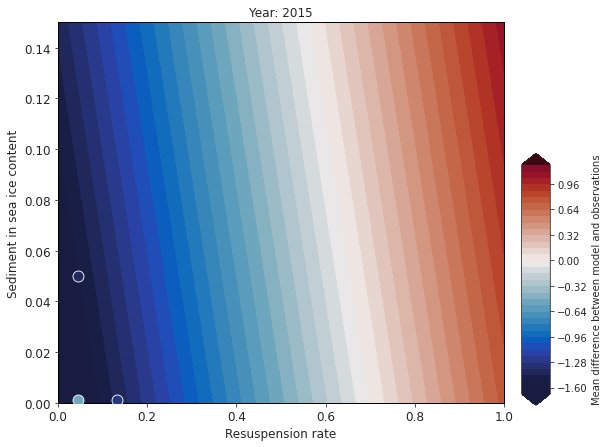

In [30]:
fig = plt.figure(figsize=(8,7))
st  = sns.axes_style("ticks")

vlow = -1.5
vup  = 1.5

with st:
    ax = sns.lineplot([-10,-9],[0,0])

    cm = plt.contourf(parameter_sets['resus_rate'][:,:,7]*gamma[7], \
                      parameter_sets['sed_ice'][:,:,7], \
                      parameter_sets['model_diff'][:,:,7], \
                      cmap=cmocean.cm.balance, levels=40, vmin=vlow, vmax=vup, extend='both')
    
    sns.scatterplot([1.0*gamma[7]], [0.05], \
                    c=[np.nanmean(oldice_2015.flatten()*10**9) - \
                      np.nanmean(observations['dissolmn'].flatten())], \
                    cmap=cmocean.cm.balance, vmin=vlow, vmax=vup, s=120, zorder=3)
    sns.scatterplot([1.0*gamma[7]], [0.001], \
                    c=[np.nanmean(gamma006_2015.flatten()*10**9) - \
                      np.nanmean(observations['dissolmn'].flatten())], \
                    cmap=cmocean.cm.balance, vmin=vlow, vmax=vup, s=120, zorder=3)
    sns.scatterplot([3.0*gamma[7]], [0.001], \
                    c=[np.nanmean(upconstant_2015.flatten()*10**9) - \
                      np.nanmean(observations['dissolmn'].flatten())], \
                    cmap=cmocean.cm.balance, vmin=vlow, vmax=vup, s=120, zorder=3)

    ax.set_xlabel('Resuspension rate', fontsize=12)
    ax.set_ylabel('Sediment in sea ice content',fontsize=12)
    ax.set_title('Year: 2015', fontsize=12)
    ax.set(xlim=(0, 1.0), ylim=(0, 0.15))
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    cbaxes = fig.add_axes([0.93, 0.12, 0.05, 0.5])
    cbar   = plt.colorbar(cm, cax=cbaxes, label='Mean difference between model and observations')
    cbar.set_clim(-1.0,1.0)
    
    ax.spines['left'].set_linewidth(1.0);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.0); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.0);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.0);    ax.spines['top'].set_color('black');    

In [40]:
print(resus_rate[12], gamma[15])

2.909090909090909 0.09493670886075949


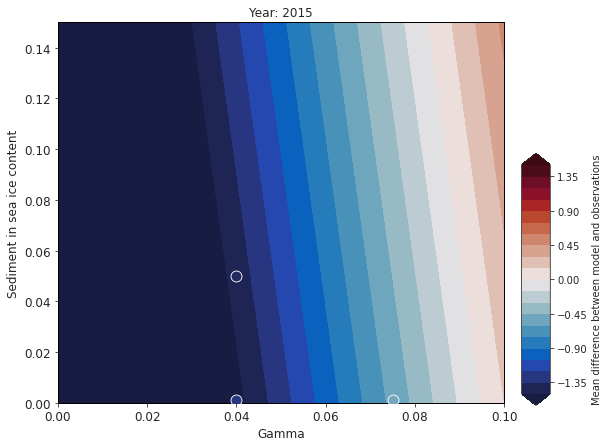

In [33]:
fig = plt.figure(figsize=(8,7))
st  = sns.axes_style("ticks")

vlow = -1.5
vup  = 1.5

# ref_2015: sediment in ice = 0.00, resuspension_constant = 1.0, gamma = 0.04
# oldice: sediment in ice = 0.05, resuspension_constant = 1.0, gamma = 0.04 (up to spinup2)
# gamma006: sediment in ice = 0.00, resuspension_constant = 1.0, gamma = 0.06 (up to spinup2)
# upconstant: sediment in ice = 0.00, resuspension_constant = 3.0, gamma = 0.04 (up to spinup0)
# Order of data: file_list = [oldref_2015, ref_2015, spinup0_2015, spinup2_2015, oldice_spinup2, gamma006_spinup2, upconstant_spinup0]

with st:
    ax = sns.lineplot([-10,-9],[0,0])

    cm = plt.contourf(parameter_sets['gamma'][12,:,:], \
                      parameter_sets['sed_ice'][12,:,:], \
                      parameter_sets['model_diff'][12,:,:], \
                      cmap=cmocean.cm.balance, levels=np.linspace(vlow,vup,21), vmin=vlow, vmax=vup, extend='both')
    
    sns.scatterplot([0.04], [0.05], \
                    c=[np.nanmean(oldice_2015.flatten()*10**9) - \
                      np.nanmean(observations['dissolmn'].flatten())], \
                    cmap=cmocean.cm.balance, vmin=vlow, vmax=vup, s=120, zorder=3)
    sns.scatterplot([0.075], [0.001], \
                    c=[np.nanmean(gamma006_2015.flatten()*10**9) - \
                      np.nanmean(observations['dissolmn'].flatten())], \
                    cmap=cmocean.cm.balance, vmin=vlow, vmax=vup, s=120, zorder=3)
    sns.scatterplot([0.04], [0.001], \
                    c=[np.nanmean(upconstant_2015.flatten()*10**9) - \
                      np.nanmean(observations['dissolmn'].flatten())], \
                    cmap=cmocean.cm.balance, vmin=vlow, vmax=vup, s=120, zorder=3)

    ax.set_xlabel('Gamma', fontsize=12)
    ax.set_ylabel('Sediment in sea ice content',fontsize=12)
    ax.set_title('Year: 2015', fontsize=12)
    ax.set(xlim=(0, 0.1), ylim=(0, 0.15))
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    cbaxes = fig.add_axes([0.93, 0.12, 0.05, 0.5])
    cbar   = plt.colorbar(cm, cax=cbaxes, label='Mean difference between model and observations')
    cbar.set_clim(-1.0,1.0)
    
    ax.spines['left'].set_linewidth(1.0);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.0); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.0);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.0);    ax.spines['top'].set_color('black');    

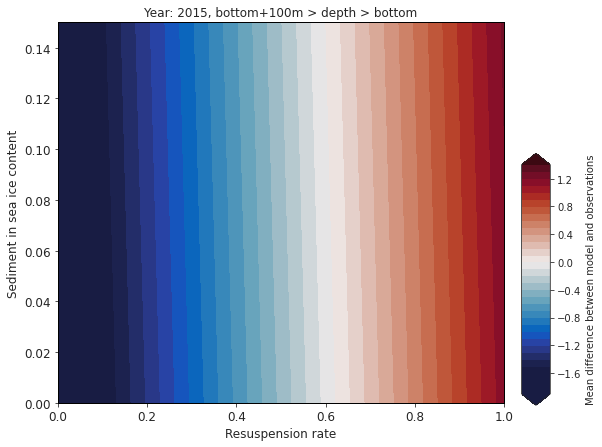

In [27]:
fig = plt.figure(figsize=(8,7))
st  = sns.axes_style("ticks")

vlow = -1.5
vup  = 1.5

with st:
    ax = sns.lineplot([-10,-9],[0,0])

    cm = plt.contourf(bottom_parameter_sets['resus_rate'][:,:,7]*gamma[7], \
                      bottom_parameter_sets['sed_ice'][:,:,7], \
                      bottom_parameter_sets['model_diff'][:,:,7], \
                      cmap=cmocean.cm.balance, levels=40, vmin=vlow, vmax=vup, extend='both')
    
    ax.set_xlabel('Resuspension rate', fontsize=12)
    ax.set_ylabel('Sediment in sea ice content',fontsize=12)
    ax.set_title('Year: 2015, bottom+100m > depth > bottom', fontsize=12)
    ax.set(xlim=(0, 1.0), ylim=(0, 0.15))
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    cbaxes = fig.add_axes([0.93, 0.12, 0.05, 0.5])
    cbar   = plt.colorbar(cm, cax=cbaxes, label='Mean difference between model and observations')
    cbar.set_clim(-1.0,1.0)
    
    ax.spines['left'].set_linewidth(1.0);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.0); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.0);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.0);    ax.spines['top'].set_color('black');    

In [41]:
resus_rate[56]*gamma[7]

0.601457614115842

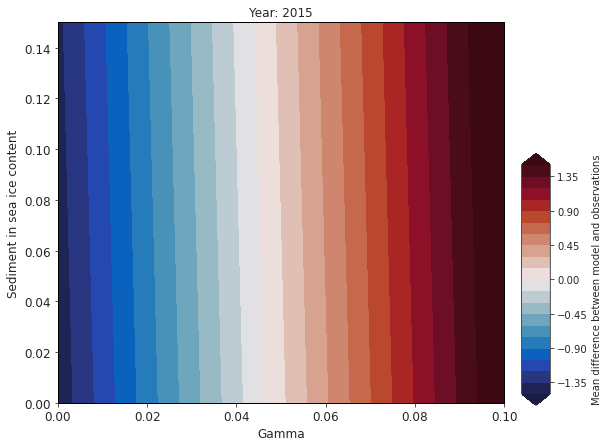

In [47]:
fig = plt.figure(figsize=(8,7))
st  = sns.axes_style("ticks")

vlow = -1.5
vup  = 1.5

with st:
    ax = sns.lineplot([-10,-9],[0,0])

    cm = plt.contourf(bottom_parameter_sets['gamma'][56,:,:], \
                      bottom_parameter_sets['sed_ice'][56,:,:], \
                      bottom_parameter_sets['model_diff'][56,:,:], \
                      cmap=cmocean.cm.balance, levels=np.linspace(vlow,vup,21), vmin=vlow, vmax=vup, extend='both')

    ax.set_xlabel('Gamma', fontsize=12)
    ax.set_ylabel('Sediment in sea ice content',fontsize=12)
    ax.set_title('Year: 2015', fontsize=12)
    ax.set(xlim=(0, 0.1), ylim=(0, 0.15))
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    cbaxes = fig.add_axes([0.93, 0.12, 0.05, 0.5])
    cbar   = plt.colorbar(cm, cax=cbaxes, label='Mean difference between model and observations')
    cbar.set_clim(-1.0,1.0)
    
    ax.spines['left'].set_linewidth(1.0);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.0); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.0);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.0);    ax.spines['top'].set_color('black');    

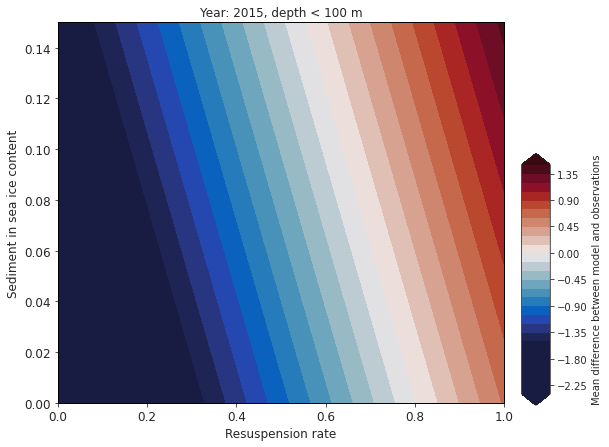

In [29]:
fig = plt.figure(figsize=(8,7))
st  = sns.axes_style("ticks")

vlow = -1.5
vup  = 1.5

with st:
    ax = sns.lineplot([-10,-9],[0,0])

    cm = plt.contourf(upper_parameter_sets['resus_rate'][:,:,7]*gamma[7], \
                      upper_parameter_sets['sed_ice'][:,:,7], \
                      upper_parameter_sets['model_diff'][:,:,7], \
                      cmap=cmocean.cm.balance, levels=40, vmin=vlow, vmax=vup, extend='both')

    ax.set_xlabel('Resuspension rate', fontsize=12)
    ax.set_ylabel('Sediment in sea ice content',fontsize=12)
    ax.set_title('Year: 2015, depth < 100 m', fontsize=12)
    ax.set(xlim=(0, 1.0), ylim=(0, 0.15))
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    cbaxes = fig.add_axes([0.93, 0.12, 0.05, 0.5])
    cbar   = plt.colorbar(cm, cax=cbaxes, label='Mean difference between model and observations')
#     cbar.set_clim(-1.5,1.0)
    
    ax.spines['left'].set_linewidth(1.0);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.0); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.0);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.0);    ax.spines['top'].set_color('black');    

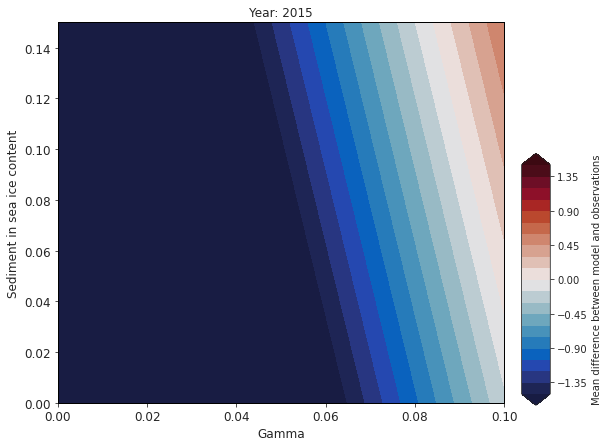

In [30]:
fig = plt.figure(figsize=(8,7))
st  = sns.axes_style("ticks")

vlow = -1.5
vup  = 1.5

with st:
    ax = sns.lineplot([-10,-9],[0,0])

    cm = plt.contourf(upper_parameter_sets['gamma'][8,:,:], \
                      upper_parameter_sets['sed_ice'][8,:,:], \
                      upper_parameter_sets['model_diff'][8,:,:], \
                      cmap=cmocean.cm.balance, levels=np.linspace(vlow,vup,21), vmin=vlow, vmax=vup, extend='both')

    ax.set_xlabel('Gamma', fontsize=12)
    ax.set_ylabel('Sediment in sea ice content',fontsize=12)
    ax.set_title('Year: 2015', fontsize=12)
    ax.set(xlim=(0, 0.1), ylim=(0, 0.15))
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    cbaxes = fig.add_axes([0.93, 0.12, 0.05, 0.5])
    cbar   = plt.colorbar(cm, cax=cbaxes, label='Mean difference between model and observations')
    cbar.set_clim(-1.0,1.0)
    
    ax.spines['left'].set_linewidth(1.0);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.0); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.0);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.0);    ax.spines['top'].set_color('black');    

So, gamma = 0.08 should represent the upper water column well, while the lower water column would do better with 0.075. 